## Prepare Data

In [9]:
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord

In [10]:
def parse_midi_files():
    """ Get all the notes and chords from the midi files in the ./midi_songs directory """
    notes = []
    songs = []

    for file in glob.glob("midi_songs/*.mid"):
        song = []
        midi = converter.parse(file)

        print("Parsing %s" % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                song.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                song.append('.'.join(str(n) for n in element.normalOrder))
        songs.append(song)
        notes += song

    return notes, songs


In [11]:
notes, songs = parse_midi_files()

Parsing midi_songs/bwv782.mid
Parsing midi_songs/bwv783.mid
Parsing midi_songs/bwv781.mid
Parsing midi_songs/bwv780.mid
Parsing midi_songs/bwv784.mid
Parsing midi_songs/bwv785.mid
Parsing midi_songs/bwv778.mid
Parsing midi_songs/bwv786.mid
Parsing midi_songs/bwv779.mid
Parsing midi_songs/bwv774.mid
Parsing midi_songs/bwv775.mid
Parsing midi_songs/bwv777.mid
Parsing midi_songs/bwv776.mid
Parsing midi_songs/bwv772.mid
Parsing midi_songs/bwv773.mid


In [21]:
max_length = 100

pitchnames = sorted(set(item for item in notes))
n_vocab = len(pitchnames)

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
int_to_note = dict([[number, note] for note, number in note_to_int.items()])

In [13]:
def prepare_sequences(notes, sequence_length=100):
    # get all pitch names
    pitchnames = sorted(set(item for item in notes))
    n_vocab = len(pitchnames)
    
    # convert notes to one-hot encoded
    one_hot_notes = []
    for note in notes:
        one_hot_note = np.zeros(n_vocab)
        one_hot_note[note_to_int[note]] = 1
        one_hot_notes.append(one_hot_note)

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(one_hot_notes) - sequence_length, 1):
        sequence_in = one_hot_notes[i:i + sequence_length]
        sequence_out = one_hot_notes[i + sequence_length]
        network_input.append(sequence_in)
        network_output.append(sequence_out)

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, n_vocab))

    network_output = np.array(network_output)

    return (network_input, network_output)

In [14]:
network_input, network_output = prepare_sequences(notes, sequence_length=max_length)

## Generator Network

In [2]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
n_vocab = 124
max_length = 100

generator_input = keras.Input(shape=(latent_dim,))

x = layers.RepeatVector(max_length)(generator_input)
x = layers.LSTM(512, return_sequences=True)(x)
    
x = layers.TimeDistributed(layers.Dense(n_vocab, activation='softmax'))(x)

generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 100, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 500)          1066000   
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 124)          62124     
Total params: 1,128,124
Trainable params: 1,128,124
Non-trainable params: 0
_________________________________________________________________


## Discriminator Network

In [5]:
discriminator_input = layers.Input(shape=(max_length, n_vocab))
x = layers.LSTM(512)(discriminator_input)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 100, 124)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 512)               1304576   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 1,305,089
Trainable params: 1,305,089
Non-trainable params: 0
_________________________________________________________________


## Adversarial Network

In [6]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [7]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32)                0         
_________________________________________________________________
model_1 (Model)              (None, 100, 124)          1128124   
_________________________________________________________________
model_2 (Model)              (None, 1)                 1305089   
Total params: 2,433,213
Trainable params: 1,128,124
Non-trainable params: 1,305,089
_________________________________________________________________


In [23]:
import os
from music21 import instrument, note, stream, chord

def create_midi(prediction_output, file_path):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.show()
    midi_stream.write('midi', fp=file_path)

In [22]:
iterations = 1000
batch_size = 20
save_dir = 'gan_midi_files/'

# Start training loop
start = 0
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_songs = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_songs = network_input[start: stop]
    combined_songs = np.concatenate([generated_songs, real_songs])

    # Assemble labels discriminating real from fake images
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels += 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_songs, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real songs"
    misleading_targets = np.zeros((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(network_input) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        prediction_indices = np.argmax(generated_songs, axis=2)

        prediction_song = [int_to_note[index] for index in prediction_indices[0]]

        # Save Generated Song Midi
        create_midi(prediction_song, os.path.join(save_dir, 'generated_song_' + str(step) + '.mid'))


/Users/masatoshi/pyenvs/music/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 1.9088207
adversarial loss at step 0: 0.7642928
discriminator loss at step 100: 0.71003246
adversarial loss at step 100: 0.9114027
discriminator loss at step 200: 0.3960938
adversarial loss at step 200: 1.4173883
discriminator loss at step 300: 0.7044975
adversarial loss at step 300: 0.86819476
discriminator loss at step 400: 0.68669665
adversarial loss at step 400: 0.752551
discriminator loss at step 500: 0.54282594
adversarial loss at step 500: 0.20970246
discriminator loss at step 600: 0.7230857
adversarial loss at step 600: 1.0537717
discriminator loss at step 700: 0.73384726
adversarial loss at step 700: 0.81442404
discriminator loss at step 800: 0.6935223
adversarial loss at step 800: 0.7368249
discriminator loss at step 900: 0.6154753
adversarial loss at step 900: 0.87149966


In [25]:
prediction_song

['G#4',
 'G#4',
 'G#4',
 'G#4',
 'G#4',
 'G#4',
 'G#4',
 '6.9',
 '6.9',
 'B5',
 'B5',
 'B5',
 'C5',
 'C5',
 'C5',
 'C5',
 'C5',
 'C5',
 'C5',
 'C5',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 '4.9',
 'C5',
 'C5',
 'C5',
 'C5',
 'C5',
 'C5',
 'C5',
 'C5',
 'C5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5',
 'E5']

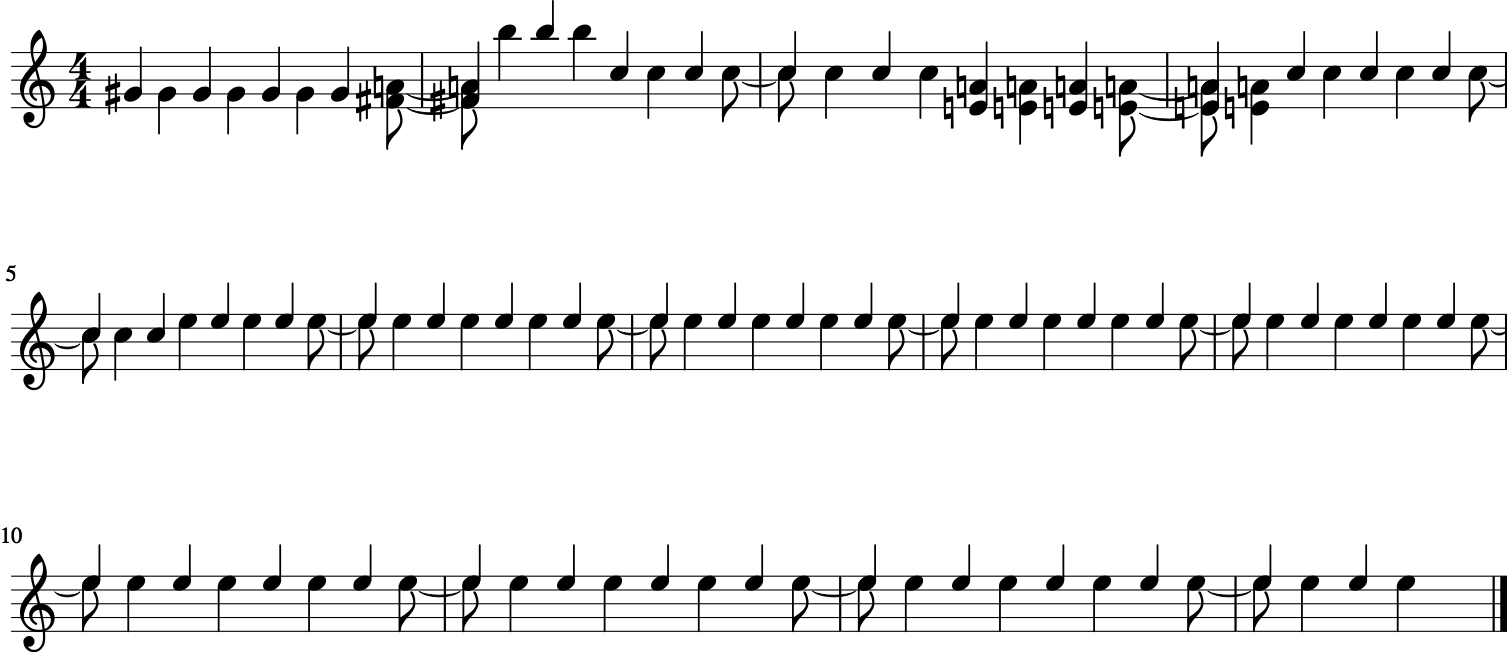

In [27]:
create_midi(prediction_song, 'test.mid')